In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import *
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import time
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col, regexp_replace, length
from pyspark.sql.types import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=79246f3ca8d8c6ef82a2526ec7a98e11157bce55022cb4b61465ea97374b91d6
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
spark = SparkSession.builder.appName("example").getOrCreate()


file_path = 'gdrive/My Drive/BigData/Final/Top2000CompaniesGlobally.csv'
data = spark.read.format("csv")\
        .option("header","true")\
        .option("inferSchema","true")\
        .load(file_path)
data.count()

Mounted at /content/gdrive


1924

In [ ]:
data.show()

+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|Global Rank|             Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|        Country|    Continent|  Latitude| Longitude|
+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|          1|                ICBC|           134.8|              37.8|           2813.5|                  237.3|          China|         Asia|  35.86166|104.195397|
|          2|China Constructio...|           113.1|              30.6|           2241.0|                  202.0|          China|         Asia|  35.86166|104.195397|
|          3|      JPMorgan Chase|           108.2|              21.3|           2359.1|                  191.4|            USA|North America|  37.09024|-95.712891|
|         

In [ ]:
data.printSchema()

root
 |-- Global Rank: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Sales ($billion): double (nullable = true)
 |-- Profits ($billion): double (nullable = true)
 |-- Assets ($billion): double (nullable = true)
 |-- Market Value ($billion): double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [ ]:
data.describe().show()

+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|summary|      Global Rank|             Company|  Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|  Country|    Continent|          Latitude|         Longitude|
+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|  count|             1924|                1924|              1924|              1924|             1924|                   1924|     1924|         1924|              1924|              1924|
|   mean|997.2328482328483|                NULL|19.265904365904273|1.2260395010395047|79.50779625779606|     19.558160083160104|     NULL|         NULL|34.618746549376155|15.455664304573906|
| stddev|575.5027807871161|                NU

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|Global Rank|Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|Country|Continent|Latitude|Longitude|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|          0|      0|               0|                 0|                0|                      0|      0|        0|       0|        0|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+



In [3]:
data.createOrReplaceTempView("data")

In [4]:
df = spark.sql("SELECT `Sales ($billion)` as Sale,`Market Value ($billion)` as MarketValue FROM data")
df.show(5)

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
+-----+-----------+
only showing top 5 rows



In [5]:
df.select('Sale').distinct().orderBy('Sales ($billion)').show(10, False)

+----+
|Sale|
+----+
|0.0 |
|0.2 |
|0.3 |
|0.4 |
|0.5 |
|0.6 |
|0.7 |
|0.8 |
|0.9 |
|1.0 |
+----+
only showing top 10 rows



In [6]:
df.select('MarketValue').distinct().orderBy('Market Value ($billion)').show(10, False)

+-----------+
|MarketValue|
+-----------+
|0.0        |
|0.1        |
|0.2        |
|0.3        |
|0.4        |
|0.5        |
|0.6        |
|0.7        |
|0.8        |
|0.9        |
+-----------+
only showing top 10 rows



In [7]:
sales = df.rdd.map(lambda p: (p.Sale)).collect()

In [8]:
sale_df = DataFrame({'Sale':sales})

In [9]:
data_min = 0.0
data_max = 469.2
data_count = 1924
data_mean = 19.26
data_stddev = 34.68

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(sale_df['Sale'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

203


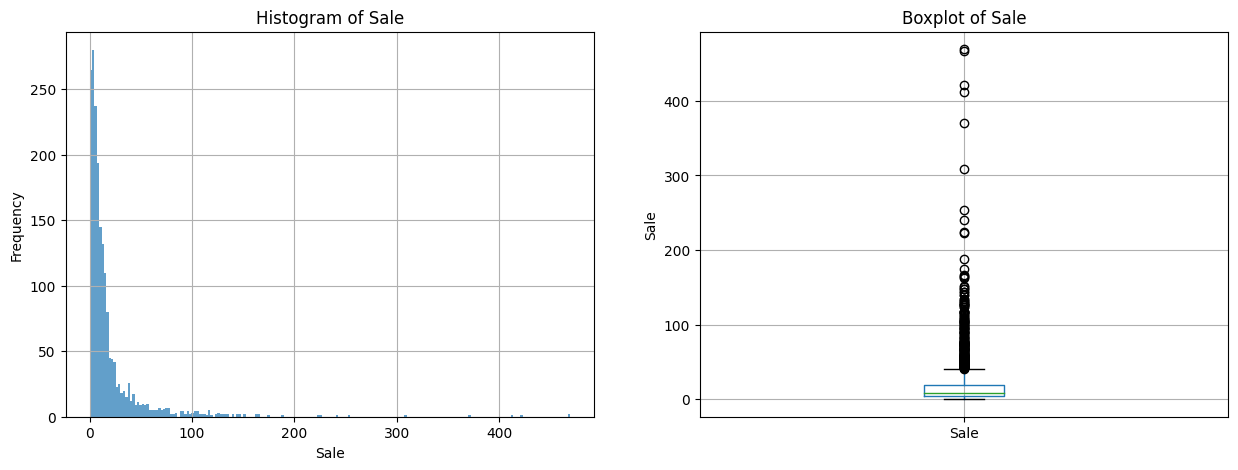

In [10]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
sale_df['Sale'].hist(bins=203, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
sale_df[['Sale']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Sale')
axes[0].set_xlabel('Sale')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Sale')

# Display the plot
plt.show()

In [11]:
market_value = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [12]:
market_value_df = DataFrame({'Market_value': market_value})

In [13]:
data_min = 0.0
data_max = 416.6
data_count = 1924
data_mean = 19.558
data_stddev = 32.957

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(market_value_df['Market_value'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

186


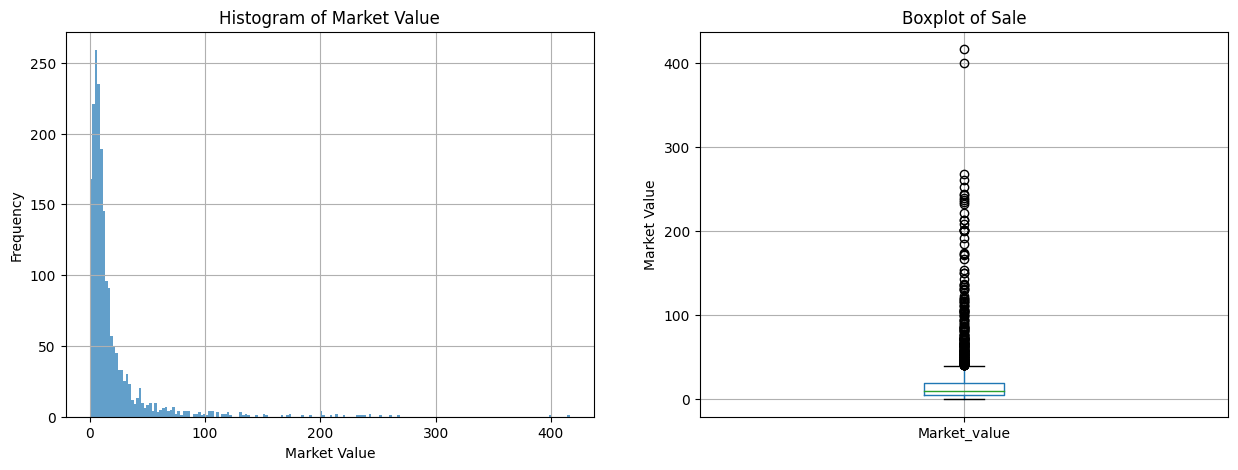

In [14]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
market_value_df['Market_value'].hist(bins=186, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
market_value_df[['Market_value']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Market Value')
axes[0].set_xlabel('Market Value')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Market Value')

# Display the plot
plt.show()

### Phân tích dữ liệu

In [15]:
x = df.rdd.map(lambda p: (p.Sale)).collect()
y = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [16]:
data_df = DataFrame({'Sale':x, 'MarketValue':y})

In [17]:
data_df.head(10)

,Sale,MarketValue
0,134.8,237.3
1,113.1,202.0
2,108.2,191.4
3,147.4,243.7
4,420.7,400.4
5,104.9,201.3
6,467.2,213.1
7,103.0,150.8
8,308.9,261.2
9,162.5,252.8


In [18]:
data_df.head(10)

,Sale,MarketValue
0,134.8,237.3
1,113.1,202.0
2,108.2,191.4
3,147.4,243.7
4,420.7,400.4
5,104.9,201.3
6,467.2,213.1
7,103.0,150.8
8,308.9,261.2
9,162.5,252.8


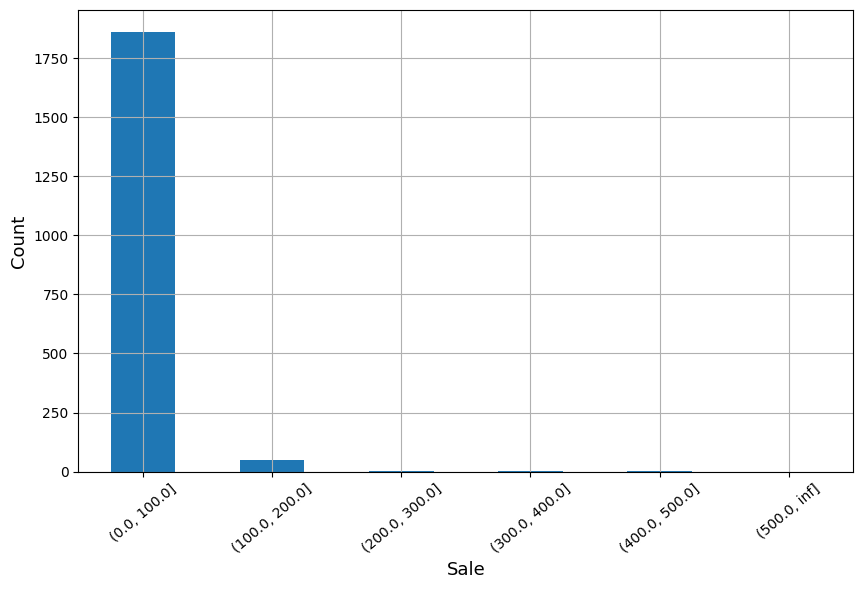

In [19]:
bins = [0, 100, 200, 300, 400, 500, float('inf')]
data_df['Sale'] = pd.cut(data_df['Sale'], bins=bins)
data_df.Sale.value_counts().sort_index().plot(kind='bar', figsize=(10,6))
plt.xlabel('Sale', fontsize= 13)
plt.ylabel('Count', fontsize = 13)
plt.xticks(rotation = 40)
plt.grid()
plt.show()

- Doanh số bán hàng trong nhóm 0 - 100 triệu đô chiếm nhiều nhất, sau đó là 100 - 200.
- Thấp nhất là trong nhóm 400 - 500 triệu đô

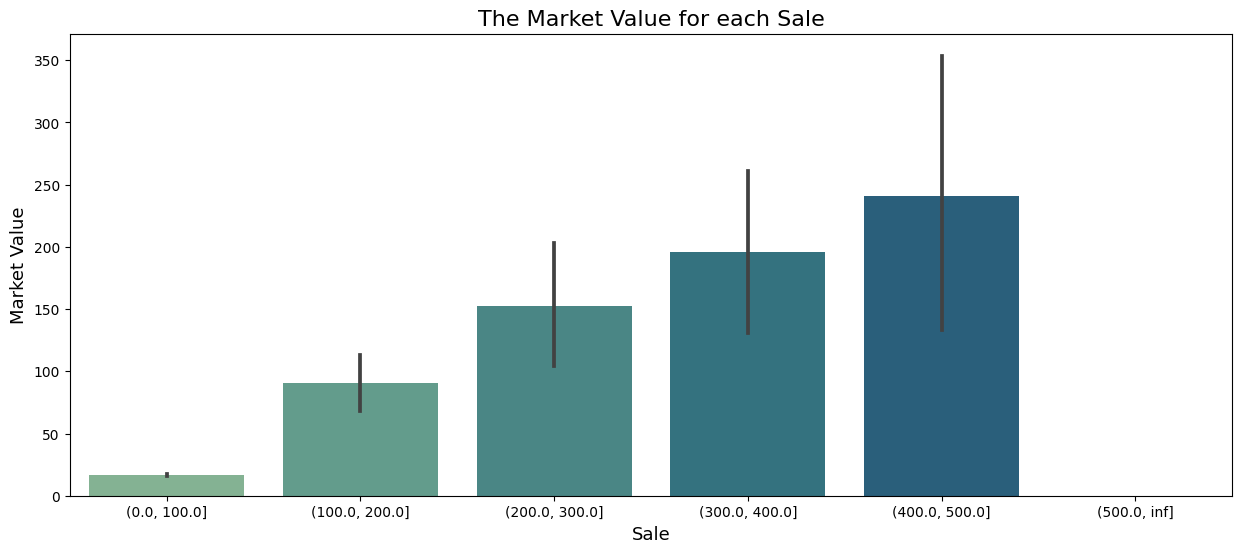

In [20]:
plt.figure(figsize=(15, 6))
sns.barplot(data = data_df, x='Sale', y='MarketValue', palette='crest')
plt.title('The Market Value for each Sale', fontsize= 16)
plt.xlabel('Sale', fontsize= 13)
plt.ylabel('Market Value', fontsize = 13)
plt.show();

- Công ty có giá trị vốn hóa càng cao thì doanh thu bán hàng càng cao, ở đây là 400 - 500.
- Bán càng nhiều hàng => giá trị trên thị trường càng cao

### Chuẩn bị dữ liệu

In [21]:
df.show()

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
|104.9|      201.3|
|467.2|      213.1|
|103.0|      150.8|
|308.9|      261.2|
|162.5|      252.8|
| 98.1|      131.7|
| 91.2|      201.3|
|222.6|      232.5|
|254.0|       94.4|
|469.2|      242.5|
|164.7|      416.6|
|144.0|      111.4|
|370.9|      130.4|
| 90.7|      143.6|
|144.1|      120.7|
+-----+-----------+
only showing top 20 rows



In [22]:
df.createOrReplaceTempView("split_data")
X = spark.sql("SELECT DOUBLE(Sale) FROM split_data")
Y = spark.sql("SELECT DOUBLE(MarketValue) FROM split_data")

In [ ]:
X.show(20)

+-----+
| Sale|
+-----+
|134.8|
|113.1|
|108.2|
|147.4|
|420.7|
|104.9|
|467.2|
|103.0|
|308.9|
|162.5|
| 98.1|
| 91.2|
|222.6|
|254.0|
|469.2|
|164.7|
|144.0|
|370.9|
| 90.7|
|144.1|
+-----+
only showing top 20 rows



In [ ]:
Y.show(20)

+-----------+
|MarketValue|
+-----------+
|      237.3|
|      202.0|
|      191.4|
|      243.7|
|      400.4|
|      201.3|
|      213.1|
|      150.8|
|      261.2|
|      252.8|
|      131.7|
|      201.3|
|      232.5|
|       94.4|
|      242.5|
|      416.6|
|      111.4|
|      130.4|
|      143.6|
|      120.7|
+-----------+
only showing top 20 rows



In [24]:
# Chia dữ liệu theo tỉ lệ train:test 7:3
X_train, X_test = X.randomSplit([0.7, 0.3], seed = 2)
Y_train, Y_test = Y.randomSplit([0.7, 0.3], seed = 2)

In [ ]:
X_train.describe().show()

+-------+------------------+
|summary|              Sale|
+-------+------------------+
|  count|              1325|
|   mean|18.790113207547183|
| stddev|34.781117916289176|
|    min|               0.0|
|    max|             469.2|
+-------+------------------+



In [ ]:
X_test.describe().show()

+-------+-----------------+
|summary|             Sale|
+-------+-----------------+
|  count|              599|
|   mean|20.31836393989984|
| stddev|34.47352379441042|
|    min|              0.3|
|    max|            467.2|
+-------+-----------------+



In [ ]:
Y_train.describe().show()

+-------+------------------+
|summary|       MarketValue|
+-------+------------------+
|  count|              1325|
|   mean|18.900000000000002|
| stddev|  31.9327848651619|
|    min|               0.0|
|    max|             416.6|
+-------+------------------+



In [ ]:
Y_test.describe().show()

+-------+-----------------+
|summary|      MarketValue|
+-------+-----------------+
|  count|              599|
|   mean|21.01402337228713|
| stddev|35.10057318333682|
|    min|              0.2|
|    max|            400.4|
+-------+-----------------+



In [25]:
rdd_X_train = X_train.rdd.map(list)
rdd_Y_train = Y_train.rdd.map(list)

In [26]:
rdd_X_test = X_test.rdd.map(list)
rdd_Y_test = Y_test.rdd.map(list)

# Hướng 1 (Linear Regression)

In [27]:
# Tính mẫu số B1 (Slope)
def deno_slope(data, mean):
    deno_slope = data.map(lambda a: (a - mean) ** 2)
    result = deno_slope.reduce(lambda a, b: a + b)
    return result

In [28]:
# Chuyển rdd_X_train thành danh sách các giá trị
rdd_X_train_1 = rdd_X_train.map(lambda a: a[0])

In [29]:
mean_X_train = rdd_X_train_1.mean()
print(mean_X_train)

18.790113207547172


In [30]:
deno_X_train = deno_slope(rdd_X_train_1, mean_X_train)
print(deno_X_train)

1601677.4404830195


In [31]:
#Chuyển rdd_X_train thành danh sách các giá trị
rdd_Y_train_1 = rdd_Y_train.map(lambda a: a[0])

In [32]:
mean_Y_train = rdd_Y_train_1.mean()
print(mean_Y_train)

18.900000000000006


In [33]:
deno_Y_train = deno_slope(rdd_Y_train_1, mean_Y_train)
print(deno_Y_train)

1350086.4400000002


In [34]:
# Tính tử số B1 (Slope)
def nume_slope(X, mean_X, Y, mean_Y):
    result = 0.0
    common_rdd = rdd_X_train_1.zip(rdd_Y_train_1)
    nume_slope = common_rdd.map(lambda a: (a[0] - mean_X) * (a[1] - mean_Y))
    result += nume_slope.reduce(lambda a, b: a + b)
    return result

In [35]:
nume_slope_xy = nume_slope(rdd_X_train_1, mean_X_train, rdd_Y_train_1, mean_Y_train)
print(nume_slope_xy)

1431582.5799999996


In [36]:
from statistics import mean

In [37]:
# Tính toán các hệ số B0 và B1
def coefficients(X, Y):
    X_mean = X.mean()
    Y_mean = Y.mean()

    common_rdd = X.zip(Y)

    nume = common_rdd.map(lambda xy: (xy[0] - X_mean) * (xy[1] - Y_mean)).sum()
    deno = common_rdd.map(lambda xy: (xy[0] - X_mean) ** 2).sum()

    b1 = nume / deno
    b0 = Y_mean - b1 * X_mean

    return [b0, b1]

In [38]:
# Hệ số của mô hình
coef = coefficients(rdd_X_train_1, rdd_Y_train_1)
print(">>>> Hệ số - B0, B1 = " + str(coef))

>>>> Hệ số - B0, B1 = [2.1053582923411227, 0.8938020501607838]


In [39]:
# Mô hình hồi quy tuyến tính để dự đoán market value
def linear_regression_1(X_train, Y_train, X_test):
    coef = coefficients(X_train, Y_train)
    b0 = coef[0]
    b1 = coef[1]
    yhat = X_test.map(lambda a: a * b1 + b0)
    return yhat

In [40]:
# Chuyển rdd_X_test thành danh sách các giá trị
rdd_X_test_1 = rdd_X_test.map(lambda a: a[0])

In [41]:
# Prediction lưu trữ kết quả dự đoán lợi nhuận
start = time.time()
prediction = linear_regression_1(rdd_X_train_1, rdd_Y_train_1, rdd_X_test_1)
end = time.time()
run_time_reg1 = end - start
print(">>>> Run time:" + str(run_time_reg1) + "(s)")

>>>> Run time:1.8029918670654297(s)


In [42]:
# Xuất kết quả dự đoán market value trên mô hình hồi quy tuyến tính
prediction_result = prediction.collect()
DataFrame({'prediction_result':prediction_result})

,prediction_result
0,2.373499
1,2.462879
2,2.552259
3,2.552259
4,2.552259
...,...
594,138.231411
595,147.348191
596,157.805675
597,229.131079


In [43]:
# Chuyển rdd_y_test thành danh sách các giá trị
rdd_Y_test_1 = rdd_Y_test.map(lambda a: a[0])

In [44]:
from math import sqrt
# Hàm tính toán RMSE
def rmse_metric(actual, predicted):
    common_rdd = actual.zip(predicted)
    prediction_error = common_rdd.map(lambda a: a[0] - a[1])
    # prediction_error.collect()
    prediction_error_square = prediction_error.map(lambda a: a ** 2)
    sum_error = prediction_error_square.reduce(lambda a, b: a + b)
    # print(sum_error)
    mean_error = sum_error / float(actual.count())
    return sqrt(mean_error)

In [45]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện bằng RMSE
def evaluate_algorithm(X_train, y_train, X_test, y_test, algorithm):
    predicted = algorithm(X_train, y_train, X_test)
    rmse = rmse_metric(y_test, predicted)
    return rmse

In [46]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
evaluate_model_HL1 = evaluate_algorithm(rdd_X_train_1, rdd_Y_train_1, rdd_X_test_1, rdd_Y_test_1, linear_regression_1)
print(">>>> Root Mean Squared Error (RMSE) = " + str(evaluate_model_HL1))

>>>> Root Mean Squared Error (RMSE) = 7.039201229422485


In [47]:
Y_test_origin = rdd_Y_test_1.collect()

In [48]:
# So sánh giữa giá trị Market Value dự đoán và giá trị gốc
compare = DataFrame({'Origin': Y_test_origin, 'Predict': prediction_result})
compare.head(10)

,Origin,Predict
0,0.2,2.373499
1,0.4,2.462879
2,0.4,2.552259
3,0.4,2.552259
4,0.5,2.552259
5,0.5,2.552259
6,0.6,2.641640
7,0.6,2.641640
8,0.6,2.641640
9,0.7,2.641640


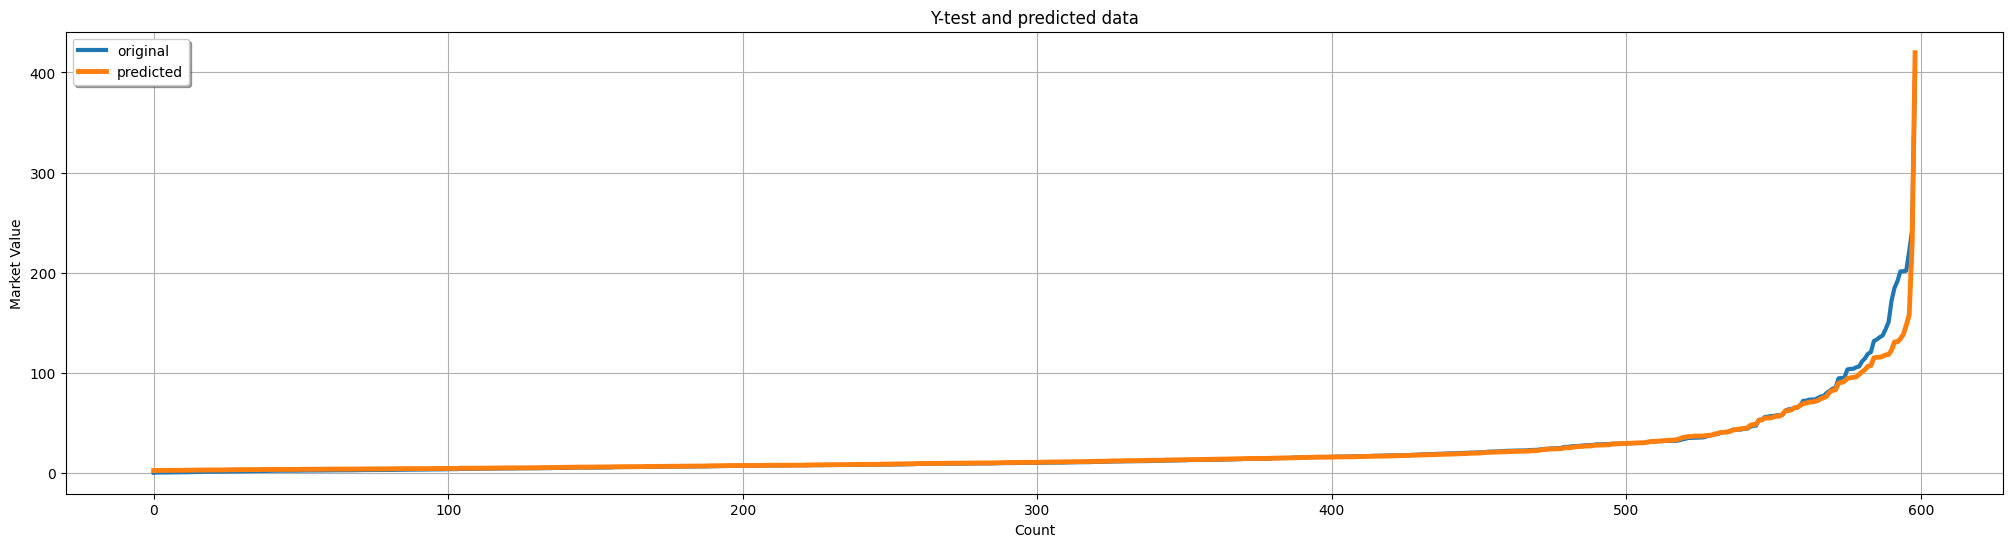

In [49]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(Y_test_origin))
plt.figure(figsize=(25, 6))
plt.plot(x_ax, Y_test_origin, linewidth=3, label="original")
plt.plot(x_ax, prediction_result, linewidth=3.5, label="predicted")
plt.title("Y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Market Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Hướng 2 (Linear Regression)

In [50]:

# Tính toán giá trị trung bình của mảng
# Đầu vào sẽ là 1 tuple (key-value)
def estimate_coef(data):
  # Số lượng phần tử trong m
  n = data.count()

  # Trung bình của mảng bao gồm các keys
  sum_x = data.keys().reduce(lambda a, b: a + b)
  mean_x = sum_x/n
  # Trung bình của mảng bao gồm các values
  sum_y = data.values().reduce(lambda a, b: a + b)
  mean_y = sum_y/n
  # Tính toán giá trị cross-deviation (độ lệch chéo) và deviation của x và y
  sum_xy = data.map(lambda x: (x[0],x[0]*x[1])).values().reduce(lambda x,y: x+y)
  SS_xy = sum_xy - n*mean_x*mean_y

  sum_xx = data.map(lambda x: (x[0],x[0]*x[0])).values().reduce(lambda x,y: x+y)
  SS_xx = sum_xx - n*mean_x*mean_x

  # Tính toán hệ số hồi quy
  b_1 = SS_xy / SS_xx
  b_0 = mean_y - b_1*mean_x

  return (b_0, b_1)

In [51]:
list_X_train_1 = rdd_X_train_1.collect()
print(list_X_train_1)

[0.0, 0.2, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.7, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5,

In [52]:
list_Y_train_1 = rdd_Y_train_1.collect()
print(list_Y_train_1)

[0.0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.8, 1.8, 1.8, 1.8, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.1, 2.1, 2.1, 2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.4, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.7, 2.7, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.3, 3.3, 3.3, 3.3, 3.3, 3.4,

In [53]:
rdd_train = rdd_X_train_1.zip(rdd_Y_train_1)

In [54]:
list_train_1 = rdd_train.collect()
print(list_train_1)

[(0.0, 0.0), (0.2, 0.1), (0.2, 0.1), (0.2, 0.2), (0.3, 0.3), (0.3, 0.3), (0.4, 0.3), (0.4, 0.4), (0.4, 0.4), (0.5, 0.4), (0.5, 0.4), (0.5, 0.4), (0.5, 0.4), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.6, 0.6), (0.6, 0.6), (0.6, 0.6), (0.6, 0.7), (0.6, 0.7), (0.6, 0.7), (0.6, 0.7), (0.6, 0.7), (0.7, 0.7), (0.7, 0.8), (0.7, 0.8), (0.7, 0.8), (0.7, 0.8), (0.8, 0.9), (0.8, 0.9), (0.8, 0.9), (0.8, 0.9), (0.8, 0.9), (0.8, 1.0), (0.8, 1.0), (0.8, 1.0), (0.8, 1.0), (0.9, 1.0), (0.9, 1.0), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.2), (0.9, 1.2), (0.9, 1.2), (0.9, 1.2), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.0, 1.3), (1.1, 1.3), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.1, 1.4), (1.2, 1.5), (1.2, 1.5), (1.2, 1.5), (1.2, 1.5), (1.2, 1.5), (1.2, 1.5), (1.2, 1.5), (1.2, 1.6), (1.2, 1.6), (1.2, 1.6), (1.2, 1.6), (1.2, 1.6), (1.

In [55]:
rdd_test = rdd_X_test_1.zip(rdd_Y_test_1)

In [56]:
# Hệ số ước lượng (estimating coefficients)
b = estimate_coef(rdd_train)
print("Hệ số ước lượng:\nb_0 = {} \nb_1 = {}".format(b[0], b[1]))

Hệ số ước lượng:
b_0 = 2.1053582923410943 
b_1 = 0.8938020501607846


In [57]:
# Hàm dự đoán - trả về các giá trị y
def linear_regression_2(train, test):
    b_0, b_1 = estimate_coef(train)
    predictions = test.keys().map(lambda x: x*b_1 + b_0)
    return predictions

In [58]:
start = time.time()
prediction = linear_regression_2(rdd_train, rdd_test)
end = time.time()
run_time_HL2 = end - start
print(">>>> Run time:" + str(run_time_HL2) + "(s)")

>>>> Run time:3.0440900325775146(s)


In [59]:
# Hàm tính toán RMSE
def rmse_metric(actual, predict):
    rdd_zip = actual.zip(predict)

    predict_error = rdd_zip.map(lambda a: a[0] - a[1])
    predict_error_square = predict_error.map(lambda a: a**2)

    sum_error = predict_error_square.reduce(lambda a,b: a+b)
    mean_error = sum_error/float(actual.count())
    rmse = math.sqrt(mean_error)
    return rmse

In [60]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
def evaluate_algorithm(train, test):
    y_test = test.values()
    y_predict = linear_regression_2(train, test)
    rmse = rmse_metric(y_test, y_predict)
    return rmse

In [61]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
import math
evaluate_model_2 = evaluate_algorithm(rdd_train, rdd_test)
print("Chỉ số RMSE: {} ".format(evaluate_model_2))

Chỉ số RMSE: 7.039201229422472 


In [62]:
Y_test = rdd_test.values().collect()

In [63]:
Y_predict = linear_regression_2(rdd_train, rdd_test).collect()

In [64]:
compare = DataFrame({'Origin': Y_test, 'Predict': Y_predict})
compare.head(5)

,Origin,Predict
0,0.2,2.373499
1,0.4,2.462879
2,0.4,2.552259
3,0.4,2.552259
4,0.5,2.552259


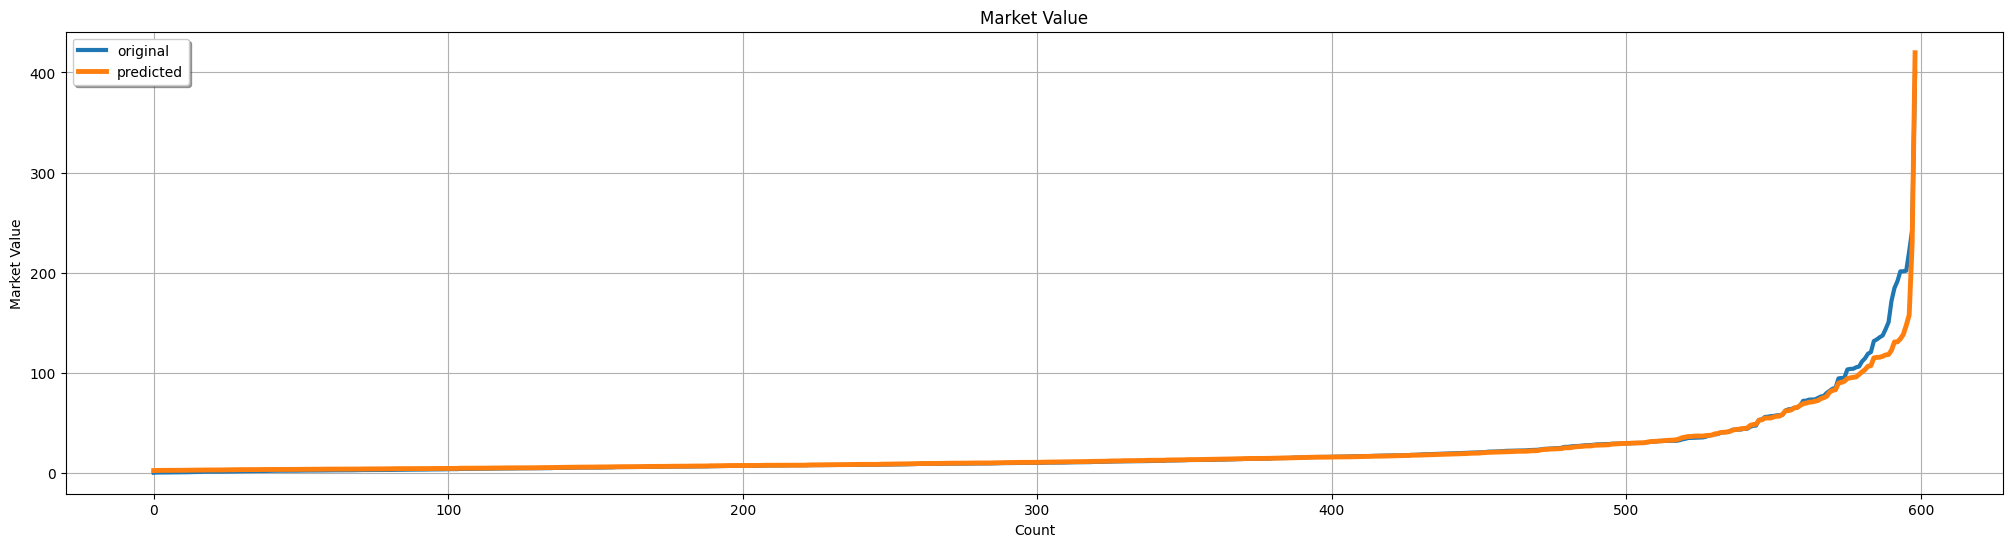

In [66]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(Y_test))
plt.figure(figsize=(25, 6))
plt.plot(x_ax, Y_test, linewidth=3, label="original")
plt.plot(x_ax, Y_predict, linewidth=3.5, label="predicted")
plt.title("Market Value")
plt.xlabel('Count')
plt.ylabel('Market Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Hướng 3 (Ridge Regression)

In [72]:
X_train_values = np.array(X_train.rdd.map(lambda x: x[0]).collect())
Y_train_values = np.array(Y_train.rdd.map(lambda x: x[0]).collect())
X_test_values = np.array(X_test.rdd.map(lambda x: x[0]).collect())

In [95]:

Y_test_values = np.array(Y_test.rdd.map(lambda x: x[0]).collect())

AttributeError: ignored

In [73]:
# Tính mean
def mean(data):
    return np.mean(data)

In [74]:
def deno_slope(data, mean):
    return np.sum((data - mean) ** 2)


In [75]:
# Hàm tính tử số
def nume_slope(X, mean_X, y, mean_y):
    common_array = np.column_stack((X, y))
    return np.sum((common_array[:, 0] - mean_X) * (common_array[:, 1] - mean_y))


In [76]:
# Hàm tính hệ số B0, B1 của Ridge Regression
def coefficients(X, y, lambda_param):
    X_mean, y_mean = mean(X), mean(y)
    b1_nume = nume_slope(X, X_mean, y, y_mean)
    b1_deno = deno_slope(X, X_mean) + lambda_param
    b1 = b1_nume / b1_deno
    b0 = y_mean - b1 * X_mean
    return b0, b1

In [77]:
# Hàm dự đoán
def predict(X, b0, b1):
    return X * b1 + b0

In [71]:
# Hàm tính hàm loss
def ridge_loss(X, y, b0, b1, lambda_param):
    y_pred = predict(X, b0, b1)
    loss = np.mean((y_pred - y) ** 2) + lambda_param * b1 ** 2
    return loss

In [78]:
lambda_param = 0.1

# Tính hệ số B0, B1 của Ridge Regression
b0, b1 = coefficients(X_train_values, Y_train_values, lambda_param)

In [79]:
# Tính hàm loss trên tập huấn luyện
loss_train = ridge_loss(X_train_values, Y_train_values, b0, b1, lambda_param)

In [93]:
# Tính hàm loss trên tập kiểm thử
loss_test = ridge_loss(X_test_values,Y_test.map(lambda x: x[0]).collect(), b0, b1, lambda_param)

AttributeError: ignored

In [86]:
print(f"Intercept (B0): {b0}")
print(f"Slope (B1): {b1}")
print(f"Loss on training set: {loss_train}")
# print(f"Loss on testing set: {loss_test}")

Intercept (B0): 2.10535934090683
Slope (B1): 0.8938019943566647
Loss on training set: 53.31384670733413


In [87]:
# Hàm tính RMSE
def rmse_metric(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

In [88]:
# Hàm đánh giá mô hình dự đoán
def evaluate_model(X, y, b0, b1):
    y_pred = predict(X, b0, b1)
    rmse = rmse_metric(y, y_pred)
    return rmse


In [89]:
# Đánh giá mô hình trên tập huấn luyện
rmse_train = evaluate_model(X_train_values, Y_train_values, b0, b1)


In [ ]:
# Đánh giá mô hình trên tập kiểm thử
rmse_test = evaluate_model(X_test_values, Y_test.rdd.map(lambda x: x[0]).collect(), b0, b1)

print(f"RMSE on training set: {rmse_train}")
print(f"RMSE on testing set: {rmse_test}")

In [90]:
start = time.time()
prediction = predict(X_test_values, b0, b1)
end = time.time()
run_time_HL3 = end - start
print(">>>> Run time:" + str(run_time_HL3) + "(s)")

>>>> Run time:0.00012421607971191406(s)


In [92]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(X_test_values))
y_test_values = Y_test.rdd.map(lambda x: x[0]).collect()
y_pred_values = predict(X_test_values, b0, b1)

plt.figure(figsize=(25, 6))
plt.plot(x_ax, y_test_values, linewidth=3, label="original")
plt.plot(x_ax, y_pred_values, linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Market Values')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

AttributeError: ignored

# So sánh thuật toán

In [97]:
run_time_reg1, run_time_HL2, run_time_HL3

(1.8029918670654297, 3.0440900325775146, 0.00012421607971191406)

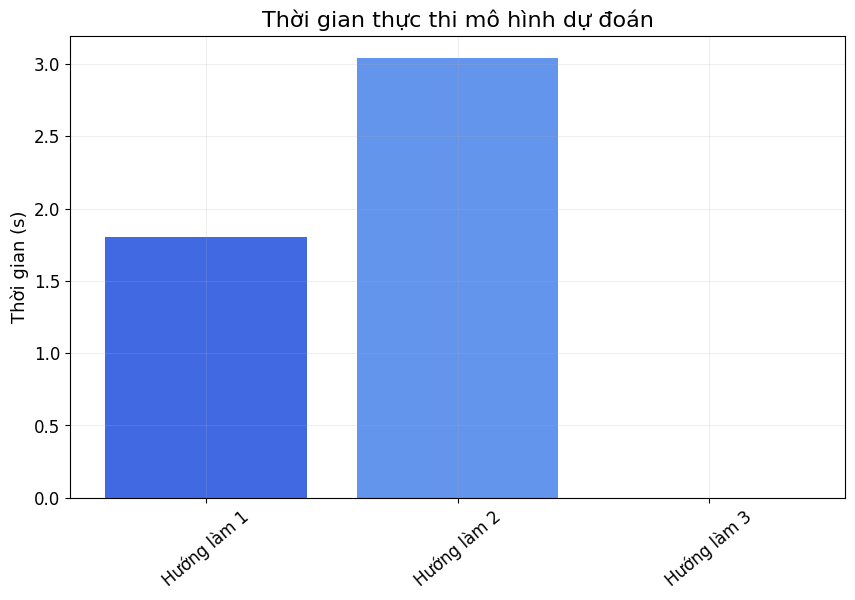

In [98]:

run_time = [run_time_reg1, run_time_HL2, run_time_HL3]
bars = ('Hướng làm 1', 'Hướng làm 2', 'Hướng làm 3')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.figure(figsize=(10,6))
plt.bar(x_pos, run_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])

# Create names on the x-axis
plt.title('Thời gian thực thi mô hình dự đoán', fontsize= 16)
plt.ylabel("Thời gian (s)",fontsize=13)
plt.xticks(x_pos, bars, fontsize=12, rotation = 40)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show();

# Show graph
plt.show()

In [ ]:
evaluate_model_HL1, evaluate_model_HL2, evaluate_model_HL3

In [ ]:
# create a dataset
run_time = [evaluate_model_HL1, evaluate_model_HL2, evaluate_model_HL3]
bars = ('Hướng làm 1', 'Hướng làm 2', 'Hướng làm 3')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.figure(figsize=(10,6))
plt.bar(x_pos, run_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])

# Create names on the x-axis
plt.title('Độ chính xác thông qua chỉ số RMSE', fontsize= 16)
plt.ylabel("Điểm đánh giá",fontsize=13)
plt.xticks(x_pos, bars, fontsize=12, rotation = 40)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show();

# Show graph
plt.show()